# 一、项目背景介绍

在当今时代，无人驾驶领域正在飞速的发展，而无人驾驶更应该严格遵守交通规则，让其能确保安全可靠的驾驶，所以车道线识别是必不可少的一项基本技能。通过计算机视觉的方法对车道线进行准确的识别，从而完成无人驾驶对路线的规划![](https://ai-studio-static-online.cdn.bcebos.com/2604307499f9482aa21b6c91a2f67d9adf53069e477a4b3f95683a6cc06e4c12)


# 二、数据介绍

本项目选择[VIL100](<https://aistudio.baidu.com/aistudio/datasetdetail/115234>)数据集，这是一个包含100个视频，10000帧图像，涵盖10种车道线类型、各种驾驶场景、光照条件和多条车道线实体，同时对视频中的所有车道线提供了高质量的实体级标注。![](https://ai-studio-static-online.cdn.bcebos.com/ba9b7ab9c7504107838a3016d154e8d8dcd2c2e741f2438b9fa7ed620b848428)



1、数据集解压
-----

In [1]:
!unzip -q /home/aistudio/data/data115234/VIL100.zip -d data/

2、数据可视化
-----

训练集数据量: 8000
测试集数据量: 2000


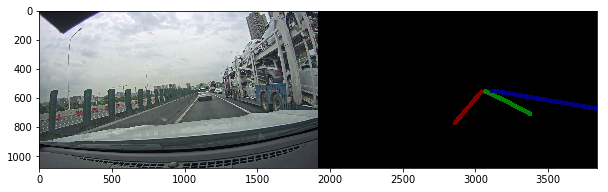

(1080, 1920, 3)
(1080, 1920, 3)


In [3]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

root = "data/VIL100"
with open("data/VIL100/data/train.txt", "r") as trainList: 
    trainDatas = trainList.readlines()
    print('训练集数据量: {}'.format(len(trainDatas)))

with open("data/VIL100/data/test.txt", "r") as testList: 
    testDatas = testList.readlines()
    print('测试集数据量: {}'.format(len(testDatas)))

# 从训练集中随机抽取一张图像进行可视化
index = random.randint(0, len(trainDatas))
traindata = trainDatas[index].split(" ")
image = cv2.imread(root + traindata[0])
label = cv2.imread(root + traindata[1])
plt.figure(figsize=(10, 10))
plt.imshow(np.hstack([image, label])[:,:,::-1])
plt.show()
print(image.shape)
print(label.shape)

# 三、模型介绍

Pix2Pix，通过随机向量z和图像x生成需要图像y，即{z,x} -> y![](https://ai-studio-static-online.cdn.bcebos.com/1c8633f3873342dbb9c8f46fa773ed316bf98901b9ec4c4cb6d89a255683f2fb)
生成器G用于生成尽可能愚弄判别器D的图像，判别器D尽可能分辨出生成器G生成的假图以及真实图像。

1、生成器搭建
----

In [ ]:
import paddle
import paddle.nn as nn

# 下采样
class Downsample(nn.Layer):
    # LeakyReLU => conv => batch norm
    def __init__(self, in_dim, out_dim, kernel_size=5, stride=1, padding=1):
        super(Downsample, self).__init__()

        self.layers = nn.Sequential(
            nn.LeakyReLU(.2),
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding),
            nn.BatchNorm2D(out_dim),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

# 上采样
class Upsample(nn.Layer):
    # ReLU => deconv => batch norm => dropout
    def __init__(self, in_dim, out_dim, kernel_size=5, stride=1, padding=1, use_dropout=False):
        super(Upsample, self).__init__()

        sequence = [
            nn.ReLU(),
            nn.Conv2DTranspose(in_dim, out_dim, kernel_size, stride, padding),
            nn.BatchNorm2D(out_dim),
        ]

        if use_dropout:
            sequence.append(nn.Dropout(p=0.5))

        self.layers = nn.Sequential(*sequence)

    def forward(self, x, skip):
        x = self.layers(x)
        x = paddle.concat([x, skip], axis=1)
        return x

# 生成器
class UnetGenerator(nn.Layer):
    def __init__(self, input_nc=3, output_nc=3, ngf=4):
        super(UnetGenerator, self).__init__()
        self.down1 = nn.Conv2D(input_nc, ngf, kernel_size=5, stride=1, padding=1)
        self.down2 = Downsample(ngf, ngf*2)
        self.down3 = Downsample(ngf*2, ngf*4)
        self.down4 = Downsample(ngf*4, ngf*8)
        self.down5 = Downsample(ngf*8, ngf*8)
        self.down6 = Downsample(ngf*8, ngf*8)
        self.down7 = Downsample(ngf*8, ngf*8)
        self.center = Downsample(ngf*8, ngf*8)
        self.up7 = Upsample(ngf*8, ngf*8, use_dropout=True)
        self.up6 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up5 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up4 = Upsample(ngf*8*2, ngf*8)
        self.up3 = Upsample(ngf*8*2, ngf*4)
        self.up2 = Upsample(ngf*4*2, ngf*2)
        self.up1 = Upsample(ngf*2*2, ngf)
        self.output_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2DTranspose(ngf*2, output_nc, kernel_size=5, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        c = self.center(d7)
        x = self.up7(c, d7)
        x = self.up6(x, d6)
        x = self.up5(x, d5)
        x = self.up4(x, d4)
        x = self.up3(x, d3)
        x = self.up2(x, d2)
        x = self.up1(x, d1)
        x = self.output_block(x)
        return x

generator = UnetGenerator()

2、判别器搭建
--

In [ ]:
class NLayerDiscriminator(nn.Layer):
    def __init__(self, input_nc=6, ndf=4):
        super(NLayerDiscriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2D(input_nc, ndf, kernel_size=3, stride=1, padding=1), 
            nn.LeakyReLU(0.2),
            ConvBlock(ndf, ndf*2),
            ConvBlock(ndf*2, ndf*4),
            ConvBlock(ndf*4, ndf*8, stride=1),
            nn.Conv2D(ndf*8, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)


class ConvBlock(nn.Layer):
    # conv => batch norm => LeakyReLU
    def __init__(self, in_dim, out_dim, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding),
            nn.BatchNorm2D(out_dim), 
            nn.LeakyReLU(.2),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

discriminator = NLayerDiscriminator()

# 四、训练模型

1、定义优化器
---

In [ ]:
from paddle.io import DataLoader

# 超参数
lr = 1e-4
BATCH_SIZE = 1
EPOCHS = 10
schedulerG = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=lr, T_max=EPOCHS*BATCH_SIZE*8000, verbose=False)
schedulerD = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=lr, T_max=EPOCHS*BATCH_SIZE*8000, verbose=False)

# 优化器
optimizerG = paddle.optimizer.Adam(
    learning_rate=schedulerG,
    parameters=generator.parameters(),
    beta1=0.5,
    beta2=0.999)

optimizerD = paddle.optimizer.Adam(
    learning_rate=schedulerD,
    parameters=discriminator.parameters(), 
    beta1=0.5,
    beta2=0.999)
    
# 损失函数
bce_loss = nn.BCELoss()
l1_loss = nn.SmoothL1Loss()

# dataloader
data_loader_train = DataLoader(
    traindataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
    )

data_loader_test = DataLoader(
    testdataset,
    batch_size=BATCH_SIZE
    )

2、训练
---

In [ ]:
import os

results_save_path = 'work/results'
os.makedirs(results_save_path, exist_ok=True)  # 保存每个epoch的测试结果

weights_save_path = 'work/weights'
os.makedirs(weights_save_path, exist_ok=True)  # 保存模型

for epoch in range(EPOCHS):
    num = 0
    for data in data_loader_train:
        num += 1
        real_A, real_B = data
        optimizerD.clear_grad()
        # D([real_A, real_B])
        real_AB = paddle.concat((real_A, real_B), 1)
        d_real_predict = discriminator(real_AB)
        d_real_loss = bce_loss(d_real_predict, paddle.ones_like(d_real_predict))

        # D([real_A, fake_B])
        fake_B = generator(real_A.detach())
        fake_AB = paddle.concat((real_A, fake_B), 1)
        d_fake_predict = discriminator(fake_AB)
        d_fake_loss = bce_loss(d_fake_predict, paddle.zeros_like(d_real_predict))
        
        # train D
        d_loss = (d_real_loss + d_fake_loss) / 2.
        d_loss.backward()
        optimizerD.step()

        optimizerG.clear_grad()
        # D([real_A, fake_B])
        fake_B = generator(real_A)
        fake_AB = paddle.concat((real_A, fake_B), 1)
        g_fake_predict = discriminator(fake_AB)
        g_bce_loss = bce_loss(g_fake_predict, paddle.ones_like(d_real_predict))
        g_l1_loss = l1_loss(real_B, fake_B)
        g_loss = g_bce_loss + g_l1_loss * 100.
        
        # train G
        g_loss.backward()
        optimizerG.step()

        if num % 200 == 0:
            # 查看训练效果
            g_output = generator(g_input)
            g_output = g_output.detach().numpy()                      # tensor -> numpy
            g_output = g_output.transpose(0, 2, 3, 1)[0]              # NCHW -> NHWC
            g_output = g_output * 127.5 + 127.5                       # 反归一化
            g_output = g_output.astype(np.uint8)

            img_show = np.hstack([image, g_output, label])[:,:,::-1]
            cv2.imwrite(os.path.join(results_save_path, 'epoch'+str(epoch+1).zfill(3)+ '_' + str(num).zfill(3)+'.png'), img_show)

            print(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.numpy()}, Loss G: {g_loss.numpy()}')

    if (epoch+1) % 1 == 0:
        paddle.save(generator.state_dict(), os.path.join(weights_save_path, 'epoch'+str(epoch+1).zfill(3)+'.pdparams'))

3、部分结果：
--
![](https://ai-studio-static-online.cdn.bcebos.com/cf522133dfec4fe5a8b6eca7ffe88938e07f1823acc64295a4bd83a943c94e20)


# 五、模型评估

In [ ]:
# 为生成器加载权重
last_weights_path = os.path.join(weights_save_path, sorted(os.listdir(weights_save_path))[-1])
print('加载权重:', last_weights_path)

model_state_dict = paddle.load(last_weights_path)
generator.load_dict(model_state_dict)
generator.eval()
# 读取数据
image = cv2.imread('data/VIL100/JPEGImages/0_Road015_Trim008_frames/00000.jpg')

g_input = image.astype('float32') / 127.5 - 1             # 归一化
g_input = g_input[np.newaxis, ...].transpose(0, 3, 1, 2)  # NHWC -> NCHW
g_input = paddle.to_tensor(g_input)                       # numpy -> tensor

g_output = generator(g_input)
g_output = g_output.detach().numpy()                      # tensor -> numpy
g_output = g_output.transpose(0, 2, 3, 1)[0]              # NCHW -> NHWC
g_output = g_output * 127.5 + 127.5                       # 反归一化
g_output = g_output.astype(np.uint8)

img_show = np.hstack([image, g_output])[:,:,::-1]
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.show()

训练效果
--

![](https://ai-studio-static-online.cdn.bcebos.com/a17f31c41e974723942c92767bab751bb3980527d9e04759a96ef21ec860ffff)


# 六、总结与升华

本项目基于GAN对抗网络实现对车道线的识别，为车道线识别的方法提供了一些不同的想法，但模型还需要进一步的改进与提升，来达到更好的效果。

# 七、个人总结

作者主页链接[<https://aistudio.baidu.com/aistudio/usercenter>]

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 